In [1]:
!pip install --upgrade pip
!pip install -q efficientnet

In [2]:
import numpy as np 
import pandas as pd

import time
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101, ResNet101V2, VGG16, VGG19, ResNet50, ResNet50V2, ResNet152, ResNet152V2, InceptionResNetV2, Xception, InceptionV3
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
print(tf.__version__)

2.4.1


In [4]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


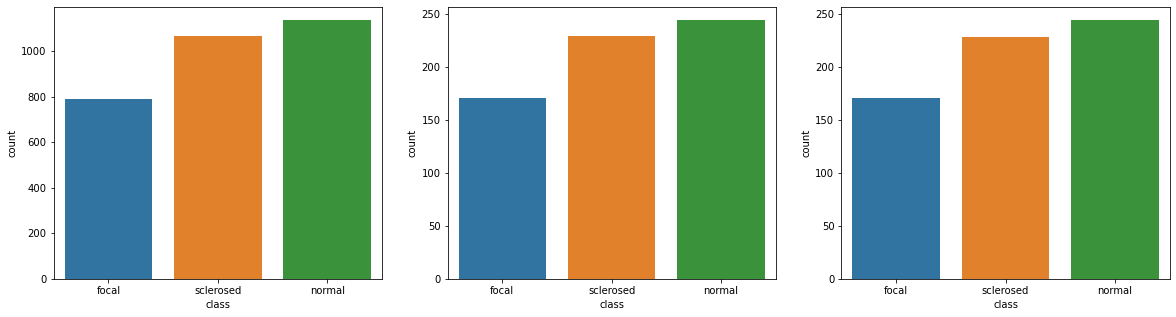

In [6]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [7]:
BUFFER_SIZE = len(train_folders)

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCH = 5
IMG_SIZE = 150

In [8]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [9]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=BUFFER_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_SIZE, IMG_SIZE))

validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                              shuffle=BUFFER_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              class_mode='categorical', 
                                                              target_size=(IMG_SIZE, IMG_SIZE))

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.


In [10]:
test_datagen = ImageDataGenerator( rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
test_generator = test_datagen.flow_from_directory(test_folders,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=BUFFER_SIZE,
                                                   class_mode='categorical',
                                                   target_size=(IMG_SIZE, IMG_SIZE))

Found 643 images belonging to 3 classes.


In [11]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'focal': 0, 'normal': 1, 'sclerosed': 2}
{0: 'focal', 1: 'normal', 2: 'sclerosed'}


In [12]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


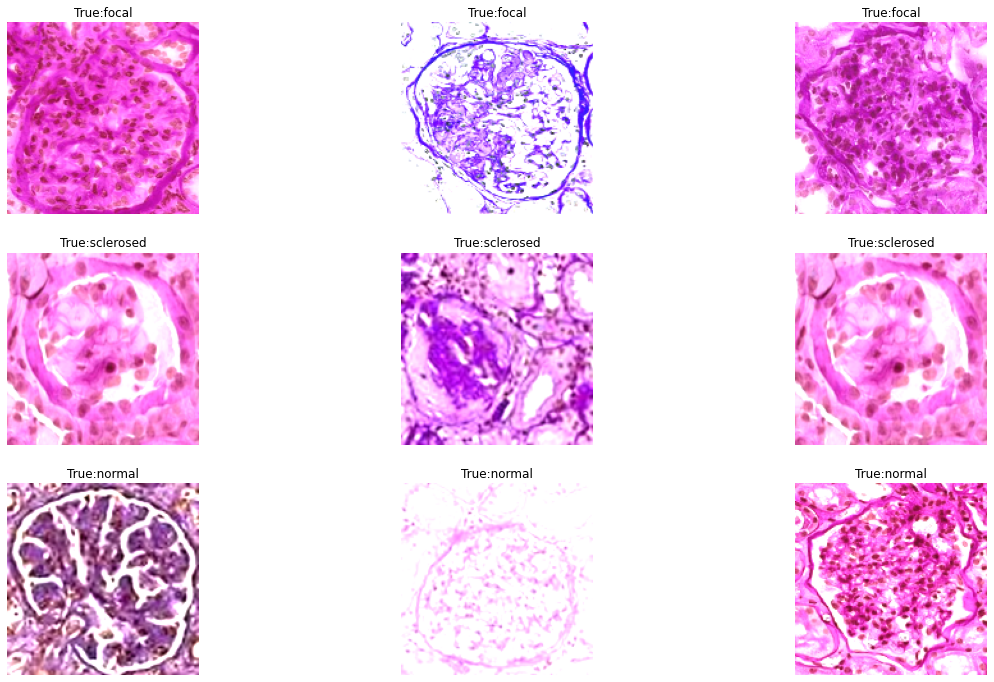

In [13]:
show_few_images(3,None)

## VGG16

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


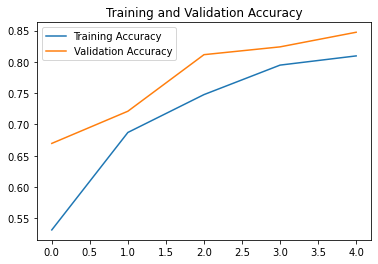

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


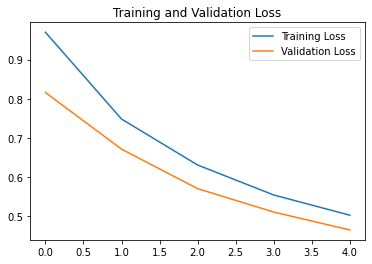

<Figure size 432x288 with 0 Axes>

In [14]:
with strategy.scope():
    vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg16_model.layers:
                layers.trainable=False
    last_output = vgg16_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg16_final_model = Model(vgg16_model.input, vgg_x)
    vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_final_model.summary()
since = time.time()
vgg16_history = vgg16_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg16_history, 'vgg16_model')

In [15]:
vgg16_final_model.evaluate(test_generator)
vgg16_best_model = vgg16_final_model

6/6 [==============================] - 15s 3s/step - loss: 0.4683 - acc: 0.8320


## VGG19

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


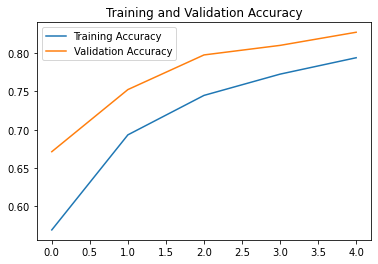

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


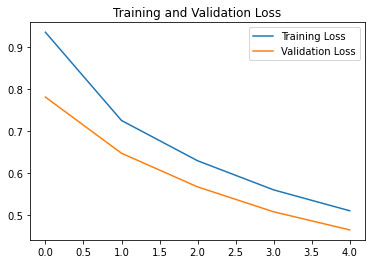

<Figure size 432x288 with 0 Axes>

In [16]:
with strategy.scope():
    vgg19_model = VGG19(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in vgg19_model.layers:
                layers.trainable=False
    last_output = vgg19_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(128, activation = 'relu')(vgg_x)
    vgg_x = Dense(3, activation = 'softmax')(vgg_x)
    vgg19_final_model = Model(vgg19_model.input, vgg_x)
    vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

vgg19_final_model.summary()
since = time.time()
vgg19_history = vgg19_final_model.fit(train_generator, epochs = EPOCH ,validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg19_history, 'vgg19_model')

In [17]:
vgg19_final_model.evaluate(test_generator)
vgg19_best_model = vgg19_final_model

6/6 [==============================] - 2s 306ms/step - loss: 0.4889 - acc: 0.8134


## ResNet50

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 216 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 216 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 312s 7s/step - loss: 2.6789 - acc: 0.5397 - val_loss: 9.5269 - val_acc: 0.3801
Epoch 2/5
24/24 [==============================] - 11s 471ms/step - loss: 0.3224 - acc: 0.8883 - val_loss: 28.5991 - val_acc: 0.3551
Epoch 3/5
24/24 [==============================] - 11s 470ms/step - loss: 0.1572 - acc: 0.9486 - val_loss: 18.6772 - val_acc: 0.2648
Epoch 4/5
24/24 [==============================] - 11s 472ms/step - loss: 0.0483 - acc: 0.9903 - val_loss: 4.9601 - val_acc: 0.3801
Epoch 5/5
24/24 [==============================] - 11s 467ms/step - loss: 0.0283 - acc: 0.9945 - val_loss: 8.3879 - val_acc: 0.2648
Elapsed Time in 359 second
Training completed in 5m 59s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


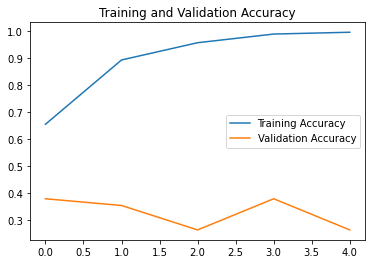

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


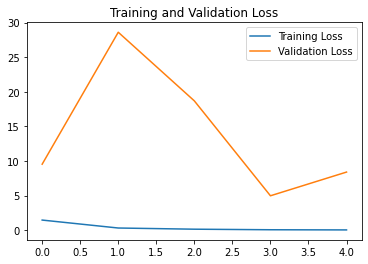

<Figure size 432x288 with 0 Axes>

In [18]:
with strategy.scope():
    ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet50_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet50_x = Flatten()(ResNet50_model.output)
    resnet50_x = Dense(256,activation='relu')(resnet50_x)
    resnet50_x = Dense(3,activation='softmax')(resnet50_x)
    resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
    resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet50_x_final_model.summary()
since = time.time()
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50_history, 'resnet50_model')

In [19]:
resnet50_x_final_model.evaluate(test_generator)
resnet50_best_model = resnet50_x_final_model

6/6 [==============================] - 25s 5s/step - loss: 8.4084 - acc: 0.2644


## ResNet50V2

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 176 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 176 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 307s 7s/step - loss: 1.3869 - acc: 0.6801 - val_loss: 0.8972 - val_acc: 0.6464
Epoch 2/5
24/24 [==============================] - 11s 470ms/step - loss: 0.0874 - acc: 0.9743 - val_loss: 0.5450 - val_acc: 0.8162
Epoch 3/5
24/24 [==============================] - 11s 471ms/step - loss: 0.0243 - acc: 0.9948 - val_loss: 0.4951 - val_acc: 0.8442
Epoch 4/5
24/24 [==============================] - 11s 467ms/step - loss: 0.0207 - acc: 0.9962 - val_loss: 0.3341 - val_acc: 0.8863
Epoch 5/5
24/24 [==============================] - 11s 470ms/step - loss: 0.0073 - acc: 0.9973 - val_loss: 0.2639 - val_acc: 0.9019
Elapsed Time in 354 second
Training completed in 5m 54s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


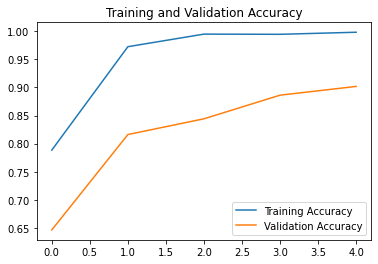

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


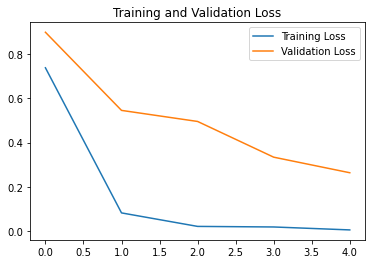

<Figure size 432x288 with 0 Axes>

In [20]:
with strategy.scope():
    ResNet50v2_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet50v2_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet50v2_x = Flatten()(ResNet50v2_model.output)
    resnet50v2_x = Dense(256,activation='relu')(resnet50v2_x)
    resnet50v2_x = Dense(3,activation='softmax')(resnet50v2_x)
    resnet50v2_x_final_model = Model(inputs=ResNet50v2_model.input, outputs=resnet50v2_x)
    resnet50v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet50v2_x_final_model.summary()
since = time.time()
resnet50v2_history = resnet50v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50v2_history, 'resnet50v2_model')

In [21]:
resnet50v2_x_final_model.evaluate(test_generator)
resnet50v2_best_model = resnet50v2_x_final_model

6/6 [==============================] - 24s 5s/step - loss: 0.2631 - acc: 0.9082


## ResNet101

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 420 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 420 all-reduces with algorithm = nccl, num_packs = 1
24/24 [==============================] - 61s 697ms/step - loss: 1.5926 - acc: 0.6647 - val_loss: 1.2305 - val_acc: 0.3551
Epoch 2/5
24/24 [==============================] - 12s 492ms/step - loss: 0.1047 - acc: 0.9640 - val_loss: 1.4929 - val_acc: 0.2648
Epoch 3/5
24/24 [==============================] - 12s 493ms/step - loss: 0.0246 - acc: 0.9952 - val_loss: 1.2845 - val_acc: 0.3801
Epoch 4/5
24/24 [==============================] - 12s 497ms/step - loss: 0.0066 - acc: 0.9997 - val_loss: 1.3197 - val_acc: 0.2648
Epoch 5/5
24/24 [==============================] - 13s 526ms/step - loss: 0.0038 - acc: 0.9996 - val_loss: 1.0742 - val_acc: 0.3801
Elapsed Time in 112 second
Training completed in 1m 52s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


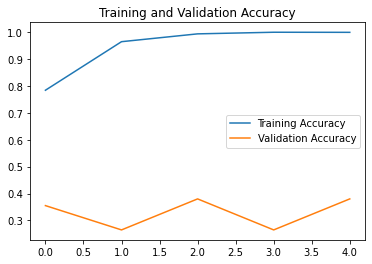

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


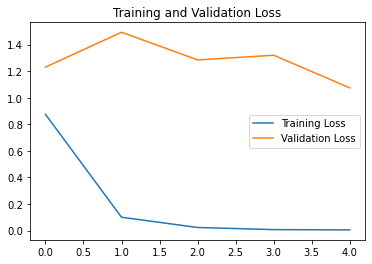

<Figure size 432x288 with 0 Axes>

In [22]:
with strategy.scope():
    ResNet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet101_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet101_x = Flatten()(ResNet101_model.output)
    resnet101_x = Dense(256,activation='relu')(resnet101_x)
    resnet101_x = Dense(3,activation='softmax')(resnet101_x)
    resnet101_x_final_model = Model(inputs=ResNet101_model.input, outputs=resnet101_x)
    resnet101_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet101_x_final_model.summary()
since = time.time()
resnet101_history = resnet101_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101_history, 'resnet101_model')

In [23]:
resnet101_x_final_model.evaluate(test_generator)
resnet101_best_model = resnet101_x_final_model

6/6 [==============================] - 2s 299ms/step - loss: 1.0746 - acc: 0.3795


## ResNet101V2

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/5
24/24 [==============================] - 59s 668ms/step - loss: 1.8941 - acc: 0.6213 - val_loss: 1.0843 - val_acc: 0.5218
Epoch 2/5
24/24 [==============================] - 12s 473ms/step - loss: 0.1786 - acc: 0.9280 - val_loss: 0.6977 - val_acc: 0.7025
Epoch 3/5
24/24 [==============================] - 12s 469ms/step - loss: 0.0466 - acc: 0.9870 - val_loss: 0.5057 - val_acc: 0.8053
Epoch 4/5
24/24 [==============================] - 12s 490ms/step - loss: 0.0186 - acc: 0.9959 - val_loss: 0.4592 - val_acc: 0.8318
Epoch 5/5
24/24 [==============================] - 12s 493ms/step - loss: 0.0065 - acc: 0.9984 - val_loss: 0.3258 - val_acc: 0.8692
Elapsed Time in 107 second
Training completed in 1m 47s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


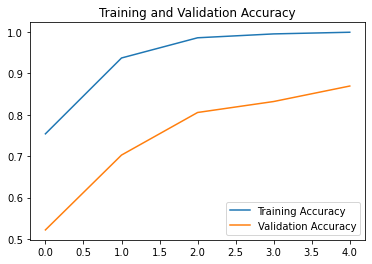

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


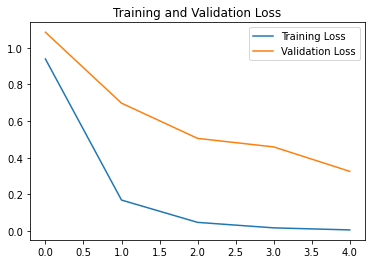

<Figure size 432x288 with 0 Axes>

In [24]:
with strategy.scope():
    ResNet101v2_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet101v2_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    # resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
    # resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
    resnet101v2_x = Flatten()(ResNet101v2_model.output)
    resnet101v2_x = Dense(256,activation='relu')(resnet101v2_x)
    resnet101v2_x = Dense(3,activation='softmax')(resnet101v2_x)
    resnet101v2_x_final_model = Model(inputs=ResNet101v2_model.input, outputs=resnet101v2_x)
    resnet101v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet101v2_x_final_model.summary()
since = time.time()
resnet101v2_history = resnet101v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101v2_history, 'resnet101v2_model')

In [25]:
resnet101v2_x_final_model.evaluate(test_generator)
resnet101v2_best_model = resnet101v2_x_final_model

6/6 [==============================] - 2s 309ms/step - loss: 0.3271 - acc: 0.8802


## ResNet152

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Total params: 71,479,171
Trainable params: 71,327,747
Non-trainable params: 151,424
__________________________________________________________________________________________________
Epoch 1/5
24/24 [==============================] - 91s 944ms/step - loss: 2.3358 - acc: 0.5422 - val_loss: 120.3247 - val_acc: 0.3551
Epoch 2/5
24/24 [==============================] - 16s 656ms/step - loss: 0.4417 - acc: 0.8669 - val_loss: 1.5300 - val_acc: 0.3551
Epoch 3/5
24/24 [==============================] - 16s 666ms/step - loss: 0.1865 - acc: 0.9358 - val_loss: 1.2052 - val_acc: 0.3551
Epoch 4/5
24/24 [==============================] - 17s 715ms/step - loss: 0.0844 - acc: 0.9783 - val_loss: 2.5082 - val_acc: 0.2648
Epoch 5/5
24/24 [==============================] - 17s 712ms/step - loss: 0.0357 - acc: 0.9948 - val_loss: 1.8254 - val_acc: 0.2648
Elapsed Time in 159 second
Training completed in 2m 39s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


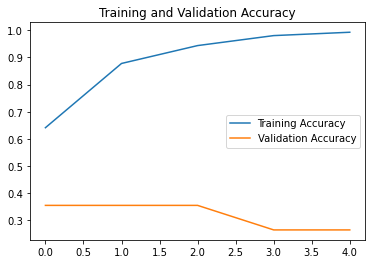

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


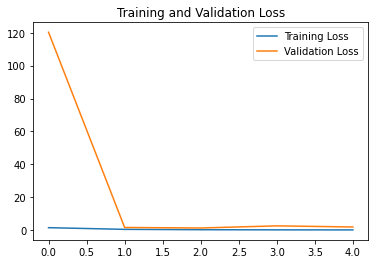

<Figure size 432x288 with 0 Axes>

In [26]:
with strategy.scope():
    ResNet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet152_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    resnet152_x = Flatten()(ResNet152_model.output)
    resnet152_x = Dense(256,activation='relu')(resnet152_x)
    resnet152_x = Dense(3,activation='softmax')(resnet152_x)
    resnet152_x_final_model = Model(inputs=ResNet152_model.input, outputs=resnet152_x)
    resnet152_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet152_x_final_model.summary()
since = time.time()
resnet152_history = resnet152_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet152_history, 'resnet152_model')

In [27]:
resnet152_x_final_model.evaluate(test_generator)
resnet152_best_model = resnet152_x_final_model

6/6 [==============================] - 2s 308ms/step - loss: 1.8276 - acc: 0.2644


## ResNet152V2

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Total params: 71,439,875
Trainable params: 71,296,131
Non-trainable params: 143,744
__________________________________________________________________________________________________
Epoch 1/5
24/24 [==============================] - 84s 865ms/step - loss: 1.9701 - acc: 0.4584 - val_loss: 294.9939 - val_acc: 0.3692
Epoch 2/5
24/24 [==============================] - 15s 598ms/step - loss: 0.6822 - acc: 0.6989 - val_loss: 6.6165 - val_acc: 0.6449
Epoch 3/5
24/24 [==============================] - 16s 638ms/step - loss: 0.4034 - acc: 0.8011 - val_loss: 1.2322 - val_acc: 0.7523
Epoch 4/5
24/24 [==============================] - 15s 607ms/step - loss: 0.2675 - acc: 0.8820 - val_loss: 1.4609 - val_acc: 0.6869
Epoch 5/5
24/24 [==============================] - 16s 649ms/step - loss: 0.2103 - acc: 0.9071 - val_loss: 0.3592 - val_acc: 0.8847
Elapsed Time in 146 second
Training completed in 2m 26s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


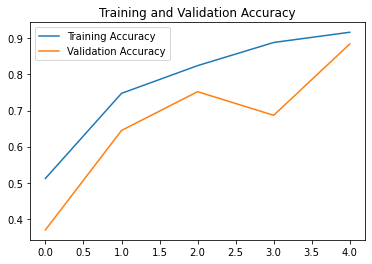

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


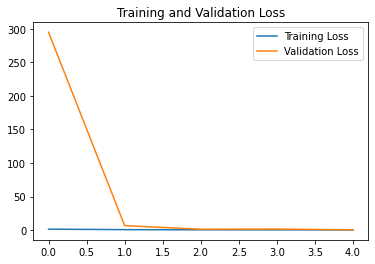

<Figure size 432x288 with 0 Axes>

In [28]:
with strategy.scope():
    ResNet152v2_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

    for layers in ResNet152v2_model.layers:
        layers.trainable=True

    opt = SGD(lr=0.01,momentum=0.7)
    resnet152v2_x = Flatten()(ResNet152v2_model.output)
    resnet152v2_x = Dense(256,activation='relu')(resnet152v2_x)
    resnet152v2_x = Dense(3,activation='softmax')(resnet152v2_x)
    resnet152v2_x_final_model = Model(inputs=ResNet152v2_model.input, outputs=resnet152v2_x)
    resnet152v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet152v2_x_final_model.summary()
since = time.time()
resnet152v2_history = resnet152v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet152v2_history, 'resnet152v2_model')

In [29]:
resnet152v2_x_final_model.evaluate(test_generator)
resnet152v2_best_model = resnet152v2_x_final_model

6/6 [==============================] - 2s 307ms/step - loss: 0.4422 - acc: 0.8429


## EfficientNetB7

last layer output shape:  (None, 2560)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
_____________________________________________________

block6g_se_expand (Conv2D)      (None, 1, 1, 2304)   223488      block6g_se_reduce[0][0]          
__________________________________________________________________________________________________
block6g_se_excite (Multiply)    (None, 5, 5, 2304)   0           block6g_activation[0][0]         
                                                                 block6g_se_expand[0][0]          
__________________________________________________________________________________________________
block6g_project_conv (Conv2D)   (None, 5, 5, 384)    884736      block6g_se_excite[0][0]          
__________________________________________________________________________________________________
block6g_project_bn (BatchNormal (None, 5, 5, 384)    1536        block6g_project_conv[0][0]       
__________________________________________________________________________________________________
block6g_drop (FixedDropout)     (None, 5, 5, 384)    0           block6g_project_bn[0][0]         
__________

Epoch 1/5
24/24 [==============================] - 601s 17s/step - loss: 1.2700 - acc: 0.4620 - val_loss: 0.6727 - val_acc: 0.7601
Epoch 2/5
24/24 [==============================] - 11s 467ms/step - loss: 0.7633 - acc: 0.6670 - val_loss: 0.5370 - val_acc: 0.7991
Epoch 3/5
24/24 [==============================] - 11s 468ms/step - loss: 0.6481 - acc: 0.7337 - val_loss: 0.5036 - val_acc: 0.7991
Epoch 4/5
24/24 [==============================] - 12s 474ms/step - loss: 0.5849 - acc: 0.7440 - val_loss: 0.4288 - val_acc: 0.8318
Epoch 5/5
24/24 [==============================] - 11s 469ms/step - loss: 0.5252 - acc: 0.7789 - val_loss: 0.3852 - val_acc: 0.8411
Elapsed Time in 650 second
Training completed in 10m 50s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


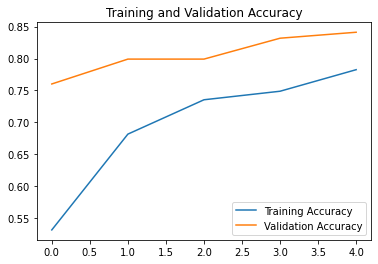

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


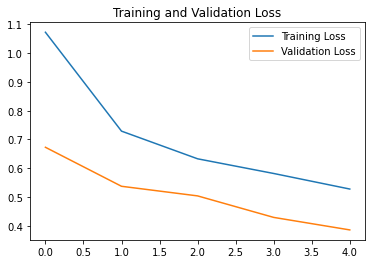

<Figure size 432x288 with 0 Axes>

In [30]:
with strategy.scope():
    effb7_model = EfficientNetB7(pooling='avg', 
                        weights='imagenet', 
                        include_top=False, 
                        input_shape=(150,150,3))
    for layers in effb7_model.layers:
                layers.trainable=False

    last_layer = effb7_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effb7_x = Flatten()(last_output)
    effb7_x = Dense(1024, activation = 'relu')(effb7_x)
    effb7_x = Dropout(0.2)(effb7_x)
    effb7_x = Dense(3, activation = 'softmax')(effb7_x)
    effb7_final_model = Model(effb7_model.input, effb7_x)
    effb7_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFB7
effb7_final_model.summary()

reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, verbose=1, mode='min', epsilon=0.0001, min_lr=0)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', restore_best_weights=True)
callbacks_list = [reduce_lr, es]

since = time.time()
effb7_history = effb7_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effb7_history, 'effb7_model')

In [31]:
effb7_final_model.evaluate(test_generator)
effb7_best_model = effb7_final_model

6/6 [==============================] - 99s 20s/step - loss: 0.4299 - acc: 0.8289


## EfficientNetL2

last layer output shape:  (None, 5504)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 136)  3672        input_10[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 136)  544         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 136)  0           stem_bn[0][0]                    
_____________________________________________________

block3h_bn (BatchNormalization) (None, 19, 19, 1056) 4224        block3h_dwconv[0][0]             
__________________________________________________________________________________________________
block3h_activation (Activation) (None, 19, 19, 1056) 0           block3h_bn[0][0]                 
__________________________________________________________________________________________________
block3h_se_squeeze (GlobalAvera (None, 1056)         0           block3h_activation[0][0]         
__________________________________________________________________________________________________
block3h_se_reshape (Reshape)    (None, 1, 1, 1056)   0           block3h_se_squeeze[0][0]         
__________________________________________________________________________________________________
block3h_se_reduce (Conv2D)      (None, 1, 1, 44)     46508       block3h_se_reshape[0][0]         
__________________________________________________________________________________________________
block3h_se

block5o_bn (BatchNormalization) (None, 10, 10, 2880) 11520       block5o_dwconv[0][0]             
__________________________________________________________________________________________________
block5o_activation (Activation) (None, 10, 10, 2880) 0           block5o_bn[0][0]                 
__________________________________________________________________________________________________
block5o_se_squeeze (GlobalAvera (None, 2880)         0           block5o_activation[0][0]         
__________________________________________________________________________________________________
block5o_se_reshape (Reshape)    (None, 1, 1, 2880)   0           block5o_se_squeeze[0][0]         
__________________________________________________________________________________________________
block5o_se_reduce (Conv2D)      (None, 1, 1, 120)    345720      block5o_se_reshape[0][0]         
__________________________________________________________________________________________________
block5o_se

Total params: 481,535,191
Trainable params: 5,640,195
Non-trainable params: 475,894,996
__________________________________________________________________________________________________
Epoch 1/5
24/24 [==============================] - 656s 19s/step - loss: 32.0951 - acc: 0.3430 - val_loss: 4.7661 - val_acc: 0.3801
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 3.6017 - acc: 0.3690 - val_loss: 1.3983 - val_acc: 0.3801
Epoch 3/5
24/24 [==============================] - 28s 1s/step - loss: 1.2774 - acc: 0.3494 - val_loss: 1.0847 - val_acc: 0.3801
Epoch 4/5
24/24 [==============================] - 29s 1s/step - loss: 1.0908 - acc: 0.3897 - val_loss: 1.0840 - val_acc: 0.3801
Epoch 5/5
24/24 [==============================] - 30s 1s/step - loss: 1.0835 - acc: 0.3904 - val_loss: 1.0883 - val_acc: 0.3551

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Elapsed Time in 775 second
Training completed in 12m 55s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


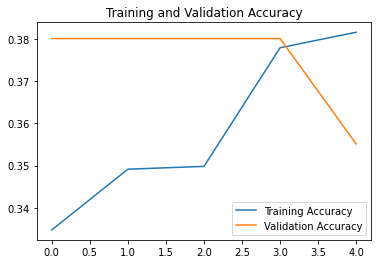

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


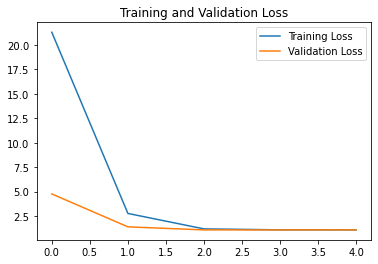

<Figure size 432x288 with 0 Axes>

In [32]:
path_weight = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/efficientnet/noisy-student/notop/efficientnet-l2_noisy-student_notop.h5'
with strategy.scope():
    effl2_model = EfficientNetL2(pooling='avg', 
                                 weights=path_weight, 
                                 include_top=False, 
                                 input_shape=(IMG_SIZE,IMG_SIZE,3),
                                 drop_connect_rate=0)
    for layers in effl2_model.layers:
                layers.trainable=False

    last_layer = effl2_model.get_layer('avg_pool')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    effl2_x = Flatten()(last_output)
    effl2_x = Dense(1024, activation = 'relu')(effl2_x)
    effl2_x = Dropout(0.2)(effl2_x)
    effl2_x = Dense(3, activation = 'softmax')(effl2_x)
    effl2_final_model = Model(effl2_model.input, effl2_x)
    effl2_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

# EFFL2
effl2_final_model.summary()

since = time.time()
effl2_history = effl2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effl2_history, 'effl2_model')

In [33]:
effl2_final_model.evaluate(test_generator)
effl2_best_model = effl2_final_model

6/6 [==============================] - 111s 22s/step - loss: 1.0881 - acc: 0.3561


## InceptionV3

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

Epoch 1/5
24/24 [==============================] - 755s 22s/step - loss: 3.9041 - acc: 0.4854 - val_loss: 0.6874 - val_acc: 0.7072
Epoch 2/5
24/24 [==============================] - 11s 450ms/step - loss: 0.5230 - acc: 0.7760 - val_loss: 0.3957 - val_acc: 0.8302
Epoch 3/5
24/24 [==============================] - 11s 452ms/step - loss: 0.3760 - acc: 0.8498 - val_loss: 0.3397 - val_acc: 0.8427
Epoch 4/5
24/24 [==============================] - 11s 450ms/step - loss: 0.2958 - acc: 0.8851 - val_loss: 0.3264 - val_acc: 0.8551
Epoch 5/5
24/24 [==============================] - 11s 448ms/step - loss: 0.2475 - acc: 0.9103 - val_loss: 0.2934 - val_acc: 0.8707
Elapsed Time in 800 second
Training completed in 13m 20s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


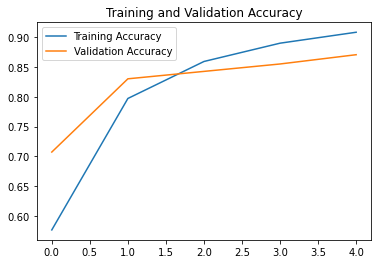

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


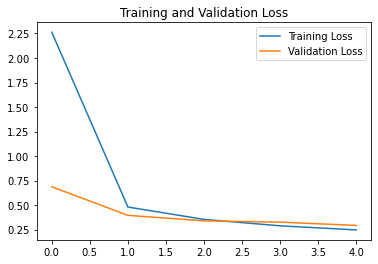

<Figure size 432x288 with 0 Axes>

In [34]:
with strategy.scope():
    incepv3_model = InceptionV3(pooling='avg', 
                              weights='imagenet', 
                              include_top=False, 
                              input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in incepv3_model.layers:
                layers.trainable=False

    incepv3_x = incepv3_model.output
    incepv3_x = Flatten()(incepv3_x)
    incepv3_x = Dense(1024, activation='relu')(incepv3_x)
    incepv3_x = Dropout(0.2)(incepv3_x)
    incepv3_x = Dense(3, activation='softmax')(incepv3_x)
    incepv3_final_model = Model(inputs=incepv3_model.input, outputs=incepv3_x)
    incepv3_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

incepv3_final_model.summary()

since = time.time()
incepv3_history = incepv3_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(incepv3_history, 'incepv3_model')

In [35]:
incepv3_final_model.evaluate(test_generator)
incepv3_best_model = incepv3_final_model

6/6 [==============================] - 123s 25s/step - loss: 0.2964 - acc: 0.8771


## InceptionResNetV2

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

batch_normalization_255 (BatchN (None, 7, 7, 288)    864         conv2d_255[0][0]                 
__________________________________________________________________________________________________
activation_250 (Activation)     (None, 7, 7, 256)    0           batch_normalization_250[0][0]    
__________________________________________________________________________________________________
activation_252 (Activation)     (None, 7, 7, 256)    0           batch_normalization_252[0][0]    
__________________________________________________________________________________________________
activation_255 (Activation)     (None, 7, 7, 288)    0           batch_normalization_255[0][0]    
__________________________________________________________________________________________________
conv2d_251 (Conv2D)             (None, 3, 3, 384)    884736      activation_250[0][0]             
__________________________________________________________________________________________________
conv2d_253

Epoch 1/5
24/24 [==============================] - 451s 13s/step - loss: 4.6132 - acc: 0.4466 - val_loss: 0.6978 - val_acc: 0.7072
Epoch 2/5
24/24 [==============================] - 11s 455ms/step - loss: 0.7046 - acc: 0.7051 - val_loss: 0.5214 - val_acc: 0.8115
Epoch 3/5
24/24 [==============================] - 11s 459ms/step - loss: 0.5318 - acc: 0.8006 - val_loss: 0.4800 - val_acc: 0.8333
Epoch 4/5
24/24 [==============================] - 11s 460ms/step - loss: 0.4551 - acc: 0.8175 - val_loss: 0.3769 - val_acc: 0.8474
Epoch 5/5
24/24 [==============================] - 11s 454ms/step - loss: 0.3903 - acc: 0.8471 - val_loss: 0.3395 - val_acc: 0.8707
Elapsed Time in 498 second
Training completed in 8m 18s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


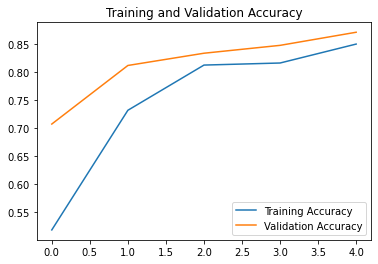

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


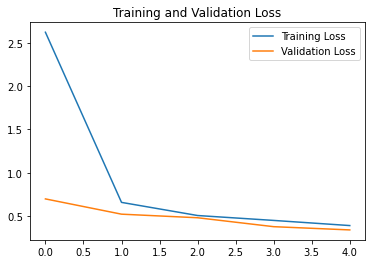

<Figure size 432x288 with 0 Axes>

In [36]:
with strategy.scope():
    inresv2_model = InceptionResNetV2(pooling='avg', 
                                      weights='imagenet', 
                                      include_top=False, 
                                      input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in inresv2_model.layers:
                layers.trainable=False

    inresv2_x = inresv2_model.output
    inresv2_x = Flatten()(inresv2_x)
    inresv2_x = Dense(1024, activation='relu')(inresv2_x)
    inresv2_x = Dropout(0.2)(inresv2_x)
    inresv2_x = Dense(3, activation='softmax')(inresv2_x)
    inresv2_final_model = Model(inputs=inresv2_model.input, outputs=inresv2_x)
    inresv2_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

inresv2_final_model.summary()

since = time.time()
inresv2_history = inresv2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(inresv2_history, 'inresv2_model')

In [37]:
inresv2_final_model.evaluate(test_generator)
inresv2_best_model = inresv2_final_model

6/6 [==============================] - 72s 14s/step - loss: 0.3758 - acc: 0.8523


## Xception

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Epoch 1/5
24/24 [==============================] - 242s 7s/step - loss: 0.8985 - acc: 0.6493 - val_loss: 0.3511 - val_acc: 0.8583
Epoch 2/5
24/24 [==============================] - 11s 450ms/step - loss: 0.3357 - acc: 0.8646 - val_loss: 0.2845 - val_acc: 0.8832
Epoch 3/5
24/24 [==============================] - 11s 452ms/step - loss: 0.2315 - acc: 0.9106 - val_loss: 0.2725 - val_acc: 0.8894
Epoch 4/5
24/24 [==============================] - 11s 455ms/step - loss: 0.2267 - acc: 0.9079 - val_loss: 0.2468 - val_acc: 0.9034
Epoch 5/5
24/24 [==============================] - 11s 452ms/step - loss: 0.1598 - acc: 0.9448 - val_loss: 0.2184 - val_acc: 0.9112
Elapsed Time in 287 second
Training completed in 4m 47s


/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


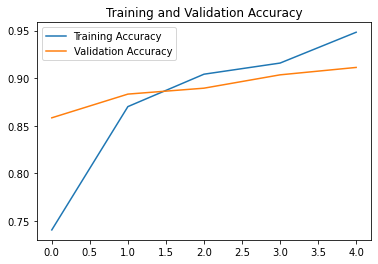

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


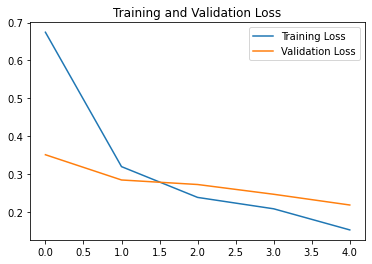

<Figure size 432x288 with 0 Axes>

In [38]:
with strategy.scope():
    xcep_model = Xception(pooling='avg', 
                          weights='imagenet', 
                          include_top=False, 
                          input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in xcep_model.layers:
                layers.trainable=False

    xcep_x = xcep_model.output
    xcep_x = Flatten()(xcep_x)
    xcep_x = Dense(1024, activation='relu')(xcep_x)
    xcep_x = Dropout(0.2)(xcep_x)
    xcep_x = Dense(3, activation='softmax')(xcep_x)
    xcep_final_model = Model(inputs=xcep_model.input, outputs=xcep_x)
    xcep_final_model.compile(loss = 'categorical_crossentropy',
                              optimizer= 'adam', 
                              metrics=['acc'])

xcep_final_model.summary()

since = time.time()
xcep_history = xcep_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(xcep_history, 'xcep_model')

In [39]:
xcep_final_model.evaluate(test_generator)
xcep_best_model = xcep_final_model

6/6 [==============================] - 41s 8s/step - loss: 0.2463 - acc: 0.9051
